In [2]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.metrics import accuracy_score, classification_report, f1_score,recall_score,accuracy_score,roc_auc_score,precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sb
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# **TF-IDF w BILSTM**

In [138]:
import os
train_fname = f"/content/gdrive/MyDrive/CS3244/CS3244/Final/Updated/full_train_preprocessed_subset.csv"

train = pd.read_csv(train_fname)
train = train.drop(columns=['Unnamed: 0'])

test_fname = f"/content/gdrive/MyDrive/CS3244/CS3244/Final/Updated/full_test_preprocessed_subset.csv"
test = pd.read_csv(test_fname)
test = test.drop(columns=['Unnamed: 0'])

val_fname = f"/content/gdrive/MyDrive/CS3244/CS3244/Final/Updated/full_val_preprocessed_subset.csv"
val = pd.read_csv(val_fname)
val = val.drop(columns=['Unnamed: 0'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [139]:
# Combine train and val and perform 0.2 train test split
print(train.shape)
train_val = train.append(val)
train_val.shape

(133999, 14)


(151222, 14)

In [140]:
train_val[['tokens']] = train_val.loc[:,['tokens']].fillna(value={})
test['tokens'] = test.loc[:,['tokens']].fillna(value={})

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = train_val['tokens'].astype(str)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
X_test = vectorizer.transform(test['tokens'].astype(str))

In [142]:
type(X)

scipy.sparse.csr.csr_matrix

In [143]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, train_val['label'], test_size = 0.2, random_state = 1)
y_test = test['label']

In [144]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.preprocessing import sequence

In [145]:
y_train

15170     0
119769    3
58026     0
48715     0
28097     2
         ..
73349     4
109259    1
50057     0
5192      4
128037    3
Name: label, Length: 120977, dtype: int64

In [146]:
from sklearn.decomposition import TruncatedSVD
transformer = TruncatedSVD(300)
X_train_v2 = transformer.fit_transform(X_train)
X_test_v2 = transformer.transform(X_test)

In [147]:
X_train_v2.shape

(120977, 300)

In [148]:
import tensorflow as tf
X_train_v2 = tf.expand_dims(X_train_v2, axis=-1)
X_test_v2 = tf.expand_dims(X_test_v2, axis=-1)

In [149]:
import tensorflow.keras.layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
model = Sequential()
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(150)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))


In [150]:
model.compile(loss='sparse_categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

In [83]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [114]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
log_folder = 'logs'
callbacks = [
            EarlyStopping(monitor = "accuracy", mode = "max", patience = 5, restore_best_weights = True, verbose = 1),
            TensorBoard(log_dir=log_folder)
            ]
num_epochs = 10
history = model.fit(X_train_v2, y_train, epochs=num_epochs, batch_size=32, callbacks=callbacks, verbose=1)

Epoch 1/10
3781/3781 [==============================] - 224s 58ms/step - loss: 1.5472 - accuracy: 0.2679
Epoch 2/10
3781/3781 [==============================] - 214s 57ms/step - loss: 1.5239 - accuracy: 0.2907
Epoch 3/10
3781/3781 [==============================] - 214s 57ms/step - loss: 1.5011 - accuracy: 0.3115
Epoch 4/10
3781/3781 [==============================] - 210s 56ms/step - loss: 1.4854 - accuracy: 0.3218
Epoch 5/10
3781/3781 [==============================] - 220s 58ms/step - loss: 1.4779 - accuracy: 0.3258
Epoch 6/10
3781/3781 [==============================] - 237s 63ms/step - loss: 1.4712 - accuracy: 0.3313
Epoch 7/10
3781/3781 [==============================] - 240s 63ms/step - loss: 1.4725 - accuracy: 0.3290
Epoch 8/10
3781/3781 [==============================] - 213s 56ms/step - loss: 1.4766 - accuracy: 0.3267
Epoch 9/10
3781/3781 [==============================] - 213s 56ms/step - loss: 1.4626 - accuracy: 0.3356
Epoch 10/10
3781/3781 [==============================] 

In [116]:
model.evaluate(X_test_v2, y_test)

534/534 [==============================] - 15s 24ms/step - loss: 1.4507 - accuracy: 0.3439


[1.4507278203964233, 0.34390202164649963]

In [117]:
predictions = model.predict(X_test_v2)
preds_classes = np.argmax(predictions,axis=1)

534/534 [==============================] - 14s 23ms/step


In [118]:
preds_classes

array([1, 1, 3, ..., 1, 0, 1])

In [119]:
print(accuracy_score(y_test,preds_classes))
print(classification_report(y_test,preds_classes))

0.3439020101975034
              precision    recall  f1-score   support

           0       0.37      0.66      0.47      3934
           1       0.29      0.52      0.37      3546
           2       0.33      0.02      0.05      2911
           3       0.42      0.32      0.36      3619
           4       0.33      0.07      0.12      3053

    accuracy                           0.34     17063
   macro avg       0.35      0.32      0.27     17063
weighted avg       0.35      0.34      0.29     17063



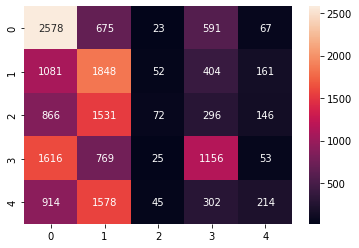

In [120]:
cf_matrix = confusion_matrix(y_test,preds_classes)  
sb.heatmap(cf_matrix, annot=True, fmt='g')

# **TF-IDF w BILSTM Tuned**

In [2]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 15.6 MB/s 
     |████████████████████████████████| 1.6 MB 61.7 MB/s 


In [3]:
import keras_tuner as kt

In [4]:
def model_builder(hp):
    model = Sequential()
    
    hp_lstm_units1 = hp.Int('bilstm_units1', 
                            min_value=32, 
                            max_value=512, 
                            step=32)
    model.add(Bidirectional(LSTM(hp_lstm_units1,return_sequences=True)))
    hp_dropout_rate1 = hp.Float('dropout_rate1', 
                               min_value=0.6, 
                               max_value=0.9, 
                               step=0.1)
    model.add(Dropout(hp_dropout_rate1))
    
    hp_lstm_units2 = hp.Int('bilstm_units2', 
                            min_value=16, 
                            max_value=512, 
                            step=32)
    model.add(Bidirectional(LSTM(hp_lstm_units2)))
    hp_dropout_rate2 = hp.Float('dropout_rate2', 
                               min_value=0.6, 
                               max_value=0.9, 
                               step=0.1)
    model.add(Dropout(hp_dropout_rate2))

    hp_dense = hp.Int('dense_unit', min_value=32, max_value=128, step=32)
    model.add(Dense(units=hp_dense,activation='relu'))

    model.add(Dense(5,activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', 
                                 values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
import keras

In [6]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)

NameError: ignored

In [156]:
import tensorflow as tf
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [1]:
tuner.search(X_train_v2, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

NameError: ignored

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model_tune = tuner.hypermodel.build(best_hps)
history = model_tune.fit(X_train_v2, y_train, epochs=10, batch_size=32,shuffle=True, callbacks=callbacks, verbose=1)

In [ ]:
model_tune = tuner.hypermodel.build(best_hps)
history = model_tune.fit(X_train_v2, y_train, epochs=50, validation_split=0.2, verbose=1)

In [ ]:
model_tune.evaluate(X_test_v2, keras.utils.to_categorical(y_test))

In [ ]:
predictions_tune = model_tune.predict(X_test_v2)
preds_classes_tune = np.argmax(predictions_tune,axis=1)

In [ ]:
print(accuracy_score(y_test,preds_classes_tune))
print(classification_report(y_test,preds_classes_tune))

In [ ]:
cf_matrix_tune = confusion_matrix(y_test,preds_classes_tune)  
sb.heatmap(cf_matrix_tune, annot=True, fmt='g')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 31.4 MB/s 
     |████████████████████████████████| 1.6 MB 44.2 MB/s 


In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow import keras
import keras_tuner as kt

def model_builder(hp):
  model = Sequential()

  # Tune the number of units in the first Dense layer
  model.add(layers.Input(shape=(300,)))
  hp_units1 = hp.Int('units1', min_value=128, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=128, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=128, step=32)
  model.add(layers.Dense(units=hp_units1, activation='relu'))
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Dense(units=hp_units2,activation='relu'))
  model.add(layers.Dropout(rate=0.25))
  model.add(layers.Dense(units=hp_units3,activation='relu'))
  model.add(layers.Dropout(rate=0.25))
  model.add(layers.Dense(5,activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3)

In [ ]:
import tensorflow as tf
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train_v2, keras.utils.to_categorical(y_train), epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 03m 44s]
val_accuracy: 0.3982889652252197

Best val_accuracy So Far: 0.3982889652252197
Total elapsed time: 00h 51m 25s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model_tune = tuner.hypermodel.build(best_hps)
history = model_tune.fit(X_train_v2, keras.utils.to_categorical(y_train), epochs=50, validation_split=0.2, verbose=1)

Epoch 1/50
3025/3025 [==============================] - 13s 4ms/step - loss: 1.5127 - accuracy: 0.3001 - val_loss: 1.4279 - val_accuracy: 0.3533
Epoch 2/50
3025/3025 [==============================] - 11s 4ms/step - loss: 1.4391 - accuracy: 0.3509 - val_loss: 1.4108 - val_accuracy: 0.3735
Epoch 3/50
3025/3025 [==============================] - 10s 3ms/step - loss: 1.4253 - accuracy: 0.3598 - val_loss: 1.4032 - val_accuracy: 0.3775
Epoch 4/50
3025/3025 [==============================] - 10s 3ms/step - loss: 1.4150 - accuracy: 0.3683 - val_loss: 1.3974 - val_accuracy: 0.3791
Epoch 5/50
3025/3025 [==============================] - 11s 4ms/step - loss: 1.4074 - accuracy: 0.3748 - val_loss: 1.3921 - val_accuracy: 0.3831
Epoch 6/50
3025/3025 [==============================] - 11s 4ms/step - loss: 1.4009 - accuracy: 0.3771 - val_loss: 1.3888 - val_accuracy: 0.3873
Epoch 7/50
3025/3025 [==============================] - 11s 4ms/step - loss: 1.3958 - accuracy: 0.3803 - val_loss: 1.3854 - val_ac

In [ ]:
model_tune.evaluate(X_test_v2, keras.utils.to_categorical(y_test))

534/534 [==============================] - 1s 2ms/step - loss: 1.3734 - accuracy: 0.3870


[1.3733593225479126, 0.3869776725769043]

In [ ]:
predictions_tune = model_tune.predict(X_test_v2)
preds_classes_tune = np.argmax(predictions_tune,axis=1)

534/534 [==============================] - 1s 1ms/step


In [ ]:
print(accuracy_score(y_test,preds_classes_tune))
print(classification_report(y_test,preds_classes_tune))

0.3869776709840005
              precision    recall  f1-score   support

           0       0.56      0.46      0.50      3934
           1       0.36      0.27      0.31      3546
           2       0.35      0.24      0.29      2911
           3       0.33      0.64      0.44      3619
           4       0.36      0.27      0.31      3053

    accuracy                           0.39     17063
   macro avg       0.39      0.38      0.37     17063
weighted avg       0.40      0.39      0.38     17063



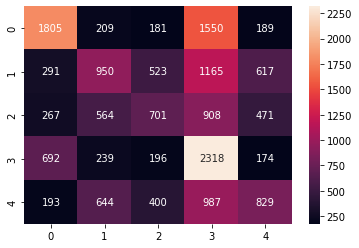

In [ ]:
cf_matrix_tune = confusion_matrix(y_test,preds_classes_tune)  
sb.heatmap(cf_matrix_tune, annot=True, fmt='g')